In [2]:
import itertools as it
import platforms as pt
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles

from config import METRICS, MONTHS, PLATFORMS, PRIMARY_KEY, TOP_N
import math
from uts import weighted_average

In [3]:
def get_colors(N):
    """
    Color generator

    Args:
        N (int): number of colors required

    Returns:
        list[str]: list of color hex values
    """
    hexadecimal_alphabets = '0123456789ABCDEF'
    color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
                            range(6)]) for i in range(N)]

    return color

# line chart


def line_chart(df_medias_months: pd.DataFrame,
               df_medias_weighted_subs: pd.DataFrame,
               platform: str = PLATFORMS[0],
               df_filter: str = '',
               metric: str = 'Subscribers',
               top_n: int = TOP_N[-1]) -> plt.figure():
    '''
    display line chart of top N influencers per social media platform
    requested over time based on a METRIC
    param:
    df_medias_months: DataFrame from platform.load_dfs(PLATFORM)
    df_medias_weighted_subs: DataFrame from weighted_average
        (df_medias_months, METRIC) if FILTER is specified,
        df_medias_months will be a
        subset of the COUNTRY or CATEGORY_1 (i.e. only providing info
        on one COUNTRY or CATEGORY_1)
    platform: platform selected
    df_filter: filter selected, if any. df_filter must be a specific
        country/category if COUNTRY/CATEGORY_1 is chosen
    metric: metric selected
    top_n: number of influencers to display restricted to 1,3,5,10

    requested_media (type: string): which social media platform's information to display

    output:
    matplotlib line chart
    '''
    figs = plt.figure()
    df_medias_weighted_subs = df_medias_weighted_subs.sort_values(
        by=[f"{metric}_TW_averge"], ascending=False).head(top_n)
    for influencer_name in df_medias_weighted_subs[PRIMARY_KEY]:
        all_influencers = df_medias_months.loc[df_medias_months[PRIMARY_KEY]
                                               == influencer_name]
        months = all_influencers['Month'].tolist()
        subs_vals = all_influencers[metric].tolist()
        plt.plot(months, subs_vals, marker='o', markersize=8, linewidth=2.0)
        plt.xlabel('Month')
        plt.ylabel('Number of ' + metric)
    plt.xticks(range(4), MONTHS)
    plt.yscale('log')
    plt.legend(df_medias_weighted_subs[PRIMARY_KEY], bbox_to_anchor = (0.5, 1.3), loc='upper center', 
               ncol=len(df_medias_weighted_subs[PRIMARY_KEY].head()))
    if df_filter == '':
        plt.title('2022 ' + platform + " Top Influencers' " +
                  metric + ' in the World')
    else:
        plt.title('2022 ' + platform + " Top Influencers' " +
                  metric + ' in ' + df_filter)

    figs.tight_layout(pad=100.0)
    return figs


def venn_diagram(df_instagram: pd.DataFrame,
                 df_youtube: pd.DataFrame,
                 months: str = MONTHS[0],
                 platform1="Instagram",
                 platform2="Youtube") -> plt.figure():
    '''
    display venn diagram comparing and contrasting countries
        for instagram and youtube
    param:
    df_instagram (type: pd.DataFrame) : UNFILTERED DataFrame of instagram data
    df_youtube (type: pd.DataFrame) : UNFILTERED DataFrame of youtube data
    month (type: string): month selected

    output:
    matplotlib_venn venn diagram
    '''

    df_filter = 'Country'
    instagram_countries = df_instagram[df_filter].dropna().unique()
    youtube_countries = df_youtube[df_filter].dropna().unique()

    # determine common countries for middle of venn
    common_countries = np.intersect1d(instagram_countries, youtube_countries)
    insta_unique = len(instagram_countries) - len(common_countries)
    assert insta_unique >= 0
    youtube_unique = len(youtube_countries) - len(common_countries)
    assert youtube_unique >= 0
    figs = plt.figure()

    def diff(list1, list2):
        return list(set(list1).symmetric_difference(set(list2)))

    df_countries = pd.DataFrame(
        it.zip_longest(diff(instagram_countries, common_countries),
                       diff(youtube_countries, common_countries),
                       common_countries,
                       fillvalue=""),
        columns=[platform1, platform2, "Both"])

    venn2(subsets=(insta_unique, youtube_unique,
                   len(common_countries)),
          set_labels=(platform1, platform2),
          set_colors=('b', 'r'),
          alpha=0.5)

    venn2_circles(
        subsets=(insta_unique,
                 youtube_unique,
                 len(common_countries)))

    plt.title(
        f"Instagram vs Youtube Number of Different Countries in {months} 2022")
    return figs, df_countries



def heatmap(df_media: pd.DataFrame,
            platform: str = PLATFORMS[0],
            month: str = MONTHS[0]) -> plt.figure():
    '''
    display heat map of the number of subscribers and top influencer
            for each category in each country for given social media platform
    param:
    df_media: UNFILTERED DataFrame of selected PLATFORM and MONTH
    platform: platform selected
    month: month selected

    output:
    seaborn heat map
    '''
    fig_count = 0
    figs = plt.figure(fig_count)
    df_platform = df_media[[PRIMARY_KEY,
                            'Category_1', 'Country', 'Subscribers']]
    all_categories = df_platform['Category_1'].unique()
    all_countries = df_platform['Country'].unique()
    new_df = pd.DataFrame(columns=all_countries, index=all_categories)
    labels = [[0 for _ in range(len(all_countries))]
              for _ in range(len(all_categories))]
    col = 0
    for country in all_countries:
        df_vals = []
        row = 0
        for category in all_categories:
            df_filtered_country = df_platform\
                .loc[df_platform['Country'] == country]
            df_filtered_category = df_filtered_country\
                .loc[df_filtered_country['Category_1'] == category]
            if len(df_filtered_category) == 0:
                df_vals.append(0)
                labels[row][col] = 'N/A'
                row += 1
                continue
            highest_following = df_filtered_category\
                .loc[df_filtered_category['Subscribers'].idxmax()]
            df_vals.append(math.log10(highest_following['Subscribers']))
            labels[row][col] = highest_following[PRIMARY_KEY]
            row += 1
        new_df[country] = df_vals
        col += 1
    # TODO : get names to appear neatly on heatmap
    ax = sns.heatmap(new_df, fmt='', cbar_kws={'label': 'log10'}, vmin=6, vmax=8)
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([6, 6.7, 7, 7.5, 8])
    c_bar.set_ticklabels(['< 6', '6.5', '7', '7.5', '> 8'])
    ax.set_title(
        f"Content consumption based on Category and Country on {platform} in {month} 2022\n\n")  # noqa: E501
    return figs


def pie_chart(df_media: pd.DataFrame,
              platform: str=PLATFORMS[0],
              month: str=MONTHS[0],
              df_filter: str='Country',
              metric: str='Subscribers', category: str='') -> plt.figure():
    '''
    if filter == 'Country':
        display pie chart of the percent of influencers that fall
        in each categories for a given country and social media platform
    if filter == 'Category_1':
        display a SINGLE pie chart of the percent each influencer contributes
        to a METRIC for a given category and social media platform
    param:
    df_media: UNFILTERED DataFrame of influencers of selected PLATFORM
            and MONTH
    platform: platform selected
    month: month selected
    df_filter: independent variable for pie chart
    metric: a single country if filter == 'Country',
            any METRICS value if filter == 'Category_1'
    category: a single category if filter == 'Category' from the dataframe

    output:
    matplotlib pie chart
    '''
    figs = plt.figure()
    if df_filter == 'Country':
        df_platform = df_media[['Category_1', df_filter]]
        df_filtered_country = df_platform.loc[df_platform[df_filter] == metric]
        count_categories = df_filtered_country.groupby('Category_1')[
            df_filter].count()
        category_divisions = count_categories.values
        category_labels = count_categories.index
        if len(category_labels) > 6:
            sorted_idx = [b[0] for b in sorted(
                enumerate(category_divisions), key=lambda i:i[1])]
            sorted_labels = []
            for i in sorted_idx:
                sorted_labels.append(category_labels[i])
            category_labels = sorted_labels[-6:]
            category_labels.insert(0, 'Misc')
            sort_category_divisions = sorted(category_divisions)
            highest_divisions = sort_category_divisions[-6:]
            other_vals = sum(sort_category_divisions[:-6])
            highest_divisions.insert(0, other_vals)
            category_divisions = highest_divisions
        explode = np.zeros(len(category_labels))
        max_val = max(category_divisions)
        max_idx = list(np.where(category_divisions == max_val))
        explode[max_idx] = 0.1
        plt.pie(category_divisions, labels=category_labels, explode=explode,
                autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
        plt.title(metric)
        plt.suptitle(
            f"Content consumption in a demographic on {platform} in {month} 2022")  # noqa: E501
    else:
        assert metric in METRICS
        assert category != ''
        df_platform = df_media[[PRIMARY_KEY, df_filter, metric]]
        df_filtered_category = df_platform\
            .loc[df_platform[df_filter] == category]
        group = df_filtered_category.groupby(PRIMARY_KEY)
        metric_df = group.apply(lambda x: x[metric].unique())
        metric_divisions = list(metric_df.values)
        metric_labels = list(metric_df.index)
        assert len(metric_labels) == len(metric_divisions)
        if len(metric_labels) > 6:
            sorted_idx = [b[0] for b in sorted(
                enumerate(metric_divisions), key=lambda i:i[1])]
            sorted_labels = []
            for i in sorted_idx:
                sorted_labels.append(metric_labels[i])
            metric_labels = sorted_labels[-6:]
            metric_labels.insert(0, 'Other')
            sort_category_divisions = sorted(metric_divisions)
            highest_divisions = sort_category_divisions[-6:]
            other_vals = sum(sort_category_divisions[:-6])
            highest_divisions.insert(0, other_vals)
            metric_divisions = highest_divisions
        explode = np.zeros(len(metric_divisions))
        max_val = max(metric_divisions)
        max_idx = list(np.where(metric_divisions == max_val))
        explode[max_idx[0]] = 0.1
        plt.pie([arr[0] for arr in metric_divisions],
                labels=metric_labels,
                explode=explode,
                autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
        plt.title(category)
        plt.suptitle(
            f"Media capture of Influencers based on {metric} on {platform} in {month} 2022")  # noqa: E501
    return figs

def bar_graph(df_media: pd.DataFrame,
              platform: str = PLATFORMS[0],
              month: str = MONTHS[0],
              df_filter: str = '',
              metric: str = '') -> plt.figure():
    '''
    display bar chart of FILTER independent variable
    and METRIC dependent variable
    param:
    df_media: FILTERED DataFrame with 2 columns:
            FILTER, METRIC
    platform: platform selected
    df_filter: filter selected
    metric: metric selected --> represents dependent variable

    output:
    matplotlib bar chart
    '''

    # TODO: Test the code
    # TODO: Check permutations of filter and metric all graph

    figs = plt.figure()
    sum_dvar = df_media.groupby(df_filter)[metric].sum()
    num_views = sum_dvar.sort_values(ascending=False).values
    ivar_names = sum_dvar.sort_values(ascending=False).index
    figs = plt.figure()
    plt.bar(ivar_names, num_views)
    plt.title('Total ' + metric + ' in Each ' + df_filter + ' on ' +
              platform + ' in ' + month + ' 2022', loc='center', fontsize=12)
    plt.xlabel(df_filter)
    plt.ylabel(metric)
    return figs


def plot_histogram(df_media: pd.DataFrame,
                   platform: str = PLATFORMS[0],
                   month: str = MONTHS[0],
                   df_filter: str = PRIMARY_KEY,
                   metric: str = '',
                   top_n: int = TOP_N[-1]) -> plt.figure():
    '''
    display bar chart histogram of METRIC dependent variable f
    or top TOP_N influencers
    param:
    df_media: FILTERED DataFrame with 2 columns: PRIMARY_KEY, METRIC
    platform: platform selected
    df_filter: PRIMARY_KEY with all influencer names
    metric: metric selected --> represents dependent variable
    top_n: number of influencers to display

    output:
    matplotlib bar chart
    '''

    figs = plt.figure()
    assert df_filter == PRIMARY_KEY
    df_media = df_media.sort_values(by=[metric], ascending=False).head(top_n)
    influencer_names = df_media[df_filter].values
    dvar = df_media[metric].values
    plt.bar(influencer_names, dvar)
    plt.title('Total ' + metric + ' for Top ' + str(top_n) +
              ' Influencers on ' +
              platform + ' in ' + month + ' 2022',
              loc='center',
              fontsize=12)
    plt.xlabel('Top ' + str(top_n) + ' ' + platform + ' Influencers')
    plt.ylabel(metric)
    return figs


def bi_directional(df_medias_months: pd.DataFrame,
                   platform: str,
                   metric: str):
    '''
    display bi-directional bar chart histogram of 5 gain and
    losses from Sep to Dec of METRIC dependent variable for influencers
    param:
    df_media_months: DF from platform.load_dfs(PLATFORM)
    platform: platform selected
    metric: metric selected --> represents dependent variable
    output:
    matplotlib bar chart
    '''

    figs = plt.figure()
    all_last_months = df_medias_months.loc[df_medias_months['Month']
                                           == 'Dec'][
        [PRIMARY_KEY, metric]]
    all_first_months = df_medias_months.loc[df_medias_months['Month']
                                            == 'Sep'][
        [PRIMARY_KEY, metric]]
    diff_months = all_last_months.set_index(PRIMARY_KEY).subtract(
        all_first_months.set_index(PRIMARY_KEY), fill_value=0)
    sorted_diffs = diff_months.sort_values(by=[metric],
                                           ascending=False)
    gains = sorted(sorted_diffs.values[:5])
    gain_accounts = list(sorted_diffs.index[:5])
    losses = sorted_diffs[-5:]
    loss_accounts = list(sorted_diffs.index[-5:])
    yvals = np.concatenate((losses, gains))
    xvals = loss_accounts + gain_accounts
    colors = ['g' if y >= 0 else 'r' for y in yvals]
    plt.barh(xvals, yvals.T[0], color=colors)
    plt.xlabel('Change in ' + metric)
    plt.ylabel(PRIMARY_KEY)
    plt.title('Top 5 ' + metric +
              ' Gain and Loss of Influencers on ' +
              platform + ' in 2022')

    return figs

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

A Data Frame of shape (3969, 9) formed!!
A Data Frame of shape (3969, 9) formed!!


C:\Users\forMED Technologies\AppData\Local\Temp\ipykernel_12120\2214112977.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  figs.tight_layout(pad=100.0)


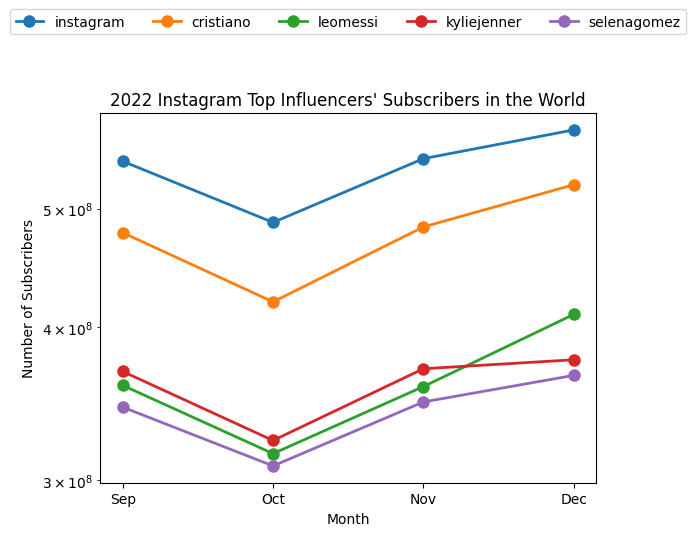

In [53]:
# line chart example
platform = 'Instagram'
metric = 'Subscribers'
top_n = 5
df_platform = pt.Social(platform)
df_medias_months = df_platform.load_dfs(platform)
df_medias_weighted_subs = weighted_average(df_medias_months, metric)
figs = line_chart(df_medias_months, df_medias_weighted_subs, platform='Instagram', top_n=top_n);

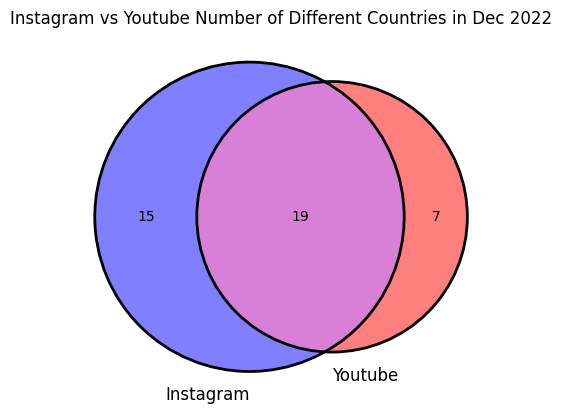

In [21]:
# venn diagram example
instagram = pd.read_csv("../data/Instagram/Instagram_Dec.csv")
youtube = pd.read_csv("../data/Youtube/Youtube_Dec.csv")
month = 'Dec'
figs, df_countries = venn_diagram(instagram, youtube, month)

A Data Frame of shape (3969, 9) formed!!


<Figure size 640x480 with 0 Axes>

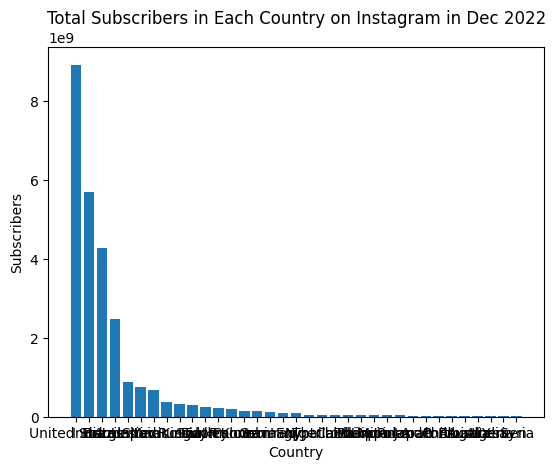

In [8]:
# bar graph example
df_filter = 'Country'
metric = 'Subscribers'
month = 'Dec'
platform = 'Instagram'
instagram = pt.Social(platform)
instagram = pt.Social.filter_by_month(instagram.df, month)
bar_graph(instagram, platform, month, df_filter, metric);

A Data Frame of shape (3969, 9) formed!!


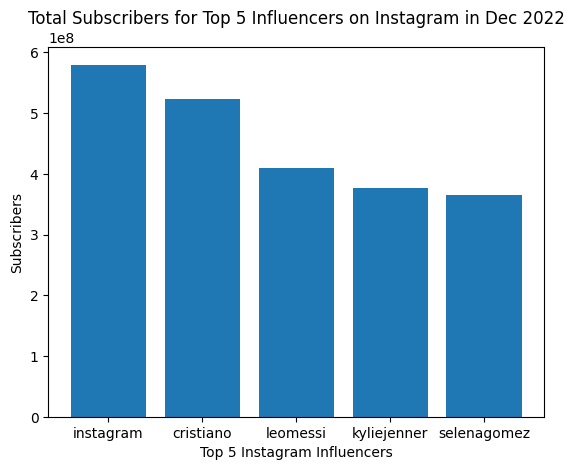

In [39]:
# histogram example
df_filter = PRIMARY_KEY
metric = 'Subscribers'
platform = 'Instagram'
month = 'Dec'
instagram = pt.Social(platform)
instagram = pt.Social.filter_by_month(instagram.df, month)
plot_histogram(instagram, platform, month, df_filter, metric, top_n=5);

A Data Frame of shape (3969, 9) formed!!


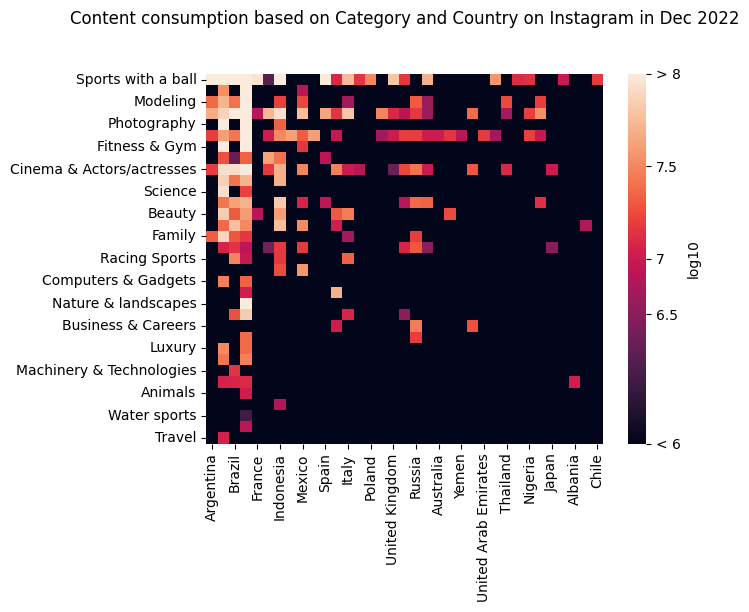

In [6]:
# heatmap
platform = 'Instagram'
month = 'Dec'
instagram = pt.Social(platform)
heatmap(instagram.filter_by_month(instagram.df, month), platform, month);

A Data Frame of shape (3969, 9) formed!!


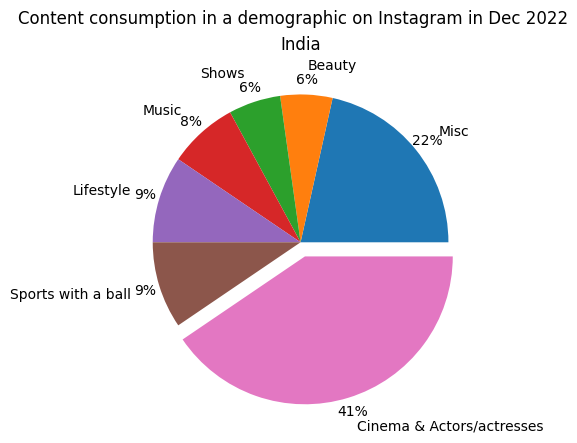

In [48]:
# pie chart
platform = 'Instagram'
month = 'Dec'
df_filter = 'Country'
metric = 'India'
instagram = pt.Social(platform)
instagram = pt.Social.filter_by_month(instagram.df, month)
pie_chart(instagram, platform, month, df_filter, metric);

A Data Frame of shape (3969, 9) formed!!


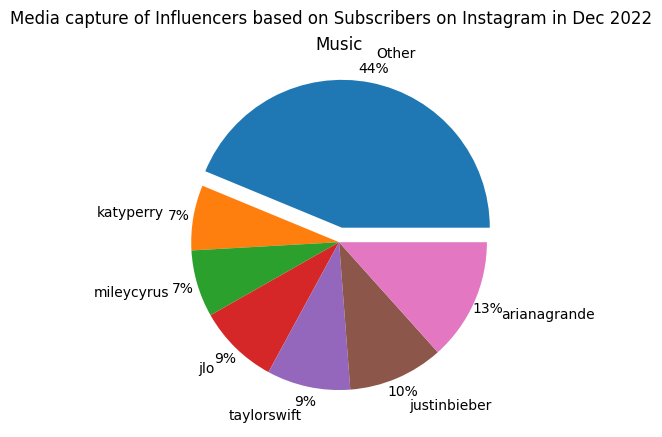

In [52]:
# pie chart
platform = 'Instagram'
month = 'Dec'
df_filter = 'Category_1'
metric = 'Subscribers'
category = 'Music'
instagram = pt.Social(platform)
instagram = pt.Social.filter_by_month(instagram.df, month)
pie_chart(instagram, platform, month, df_filter, metric, category);

A Data Frame of shape (3969, 9) formed!!
A Data Frame of shape (3969, 9) formed!!


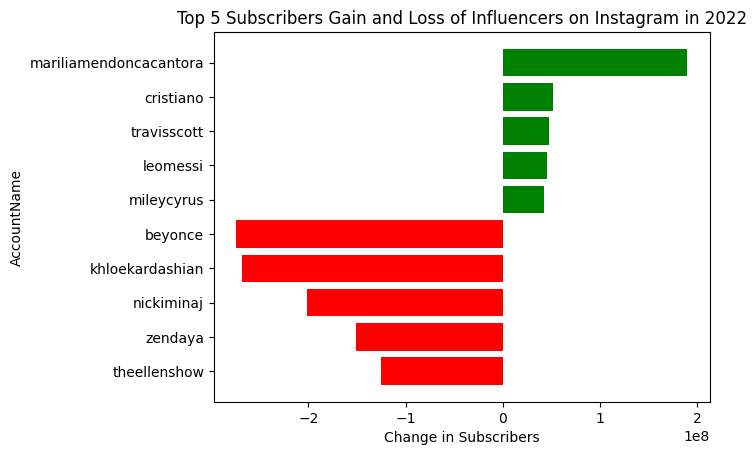

In [44]:
p = 'Instagram'
platform = pt.Social(p)
df_medias_months = platform.load_dfs(p)
df_medias_weighted_subs = weighted_average(df_medias_months, 'Subscribers')
bi_directional(df_medias_months, platform=p, metric='Subscribers');